# Project 4: Classifying Homes

In [11]:
import pandas as pd
import altair as alt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [12]:
dwellings_ml = pd.read_csv("dwellings_ml.csv")
dwellings_denver = pd.read_csv("dwellings_denver.csv")

## Question 1

Create 2-3 charts that evaluate potential relationships between the house variables and the variable before1980 Explain what you learn from the charts that could help a machine learning algorithm.

### Chart 1: Number of Bathrooms in Houses Built Before 1980

In [13]:
numbaths1980_df = dwellings_ml.value_counts(['before1980','numbaths']).reset_index().rename(columns={0:'count'})
numbaths1980_df["time_description"] = np.where(numbaths1980_df['before1980']==1, "Before 1980", "After 1980")
numbaths1980_df

,before1980,numbaths,count,time_description
0,1,2,6313,Before 1980
1,1,1,4767,Before 1980
2,0,3,3493,After 1980
3,1,3,2403,Before 1980
4,0,2,2002,After 1980
5,0,4,1787,After 1980
6,0,1,709,After 1980
7,1,4,625,Before 1980
8,0,5,424,After 1980
9,1,5,138,Before 1980


In [14]:
chart = (alt.Chart(numbaths1980_df)
        .encode(x= alt.X("numbaths", title = "Number of Bathrooms", ),
                y = alt.Y("count", title = "Number of Houses with x Num of Bathrooms", ),
                color= alt.Color("time_description:N",title="Year Built"))
        .mark_bar()
        .properties(title = "Most Houses Built Before 1980 Have 1 to 2 Bathrooms"))

chart

alt.Chart(...)

### Chart 2: Condition of All the Houses in the Dataset

In [15]:
condition_before1980 = dwellings_denver.value_counts(['yrbuilt','condition']).reset_index().rename(columns={0:'count'})
condition_before1980 = condition_before1980[condition_before1980["yrbuilt"]<= 1980] 
condition_before1980

,yrbuilt,condition,count
6,1955,AVG,391
7,1954,AVG,354
12,1952,AVG,314
13,1953,AVG,309
16,1951,AVG,283
...,...,...,...
361,1919,VGood,1
362,1919,Excel,1
363,1918,VGood,1
364,1917,Excel,1


In [16]:
num_condition_before1980 = (condition_before1980.groupby("condition")
    .agg(total_houses_by_condition = ("count", sum))
    .sort_values('total_houses_by_condition', ascending = False)
    .reset_index())
print(num_condition_before1980.to_markdown())

|    | condition   |   total_houses_by_condition |
|---:|:------------|----------------------------:|
|  0 | AVG         |                        9938 |
|  1 | Good        |                        4207 |
|  2 | VGood       |                         325 |
|  3 | Excel       |                           8 |
|  4 | Fair        |                           1 |


In [17]:
chart2 = (alt.Chart(condition_before1980)
        .encode(x= alt.X("yrbuilt:Q", title = "Year Built" ),
                y = alt.Y("count:Q", title = "Number of Houses with x Condition" ),
                color= alt.Color("condition:N",title="Condition"))
        .mark_bar()
        .properties(title="Most Houses Built Before 1980 Have an Average Condition"))

chart2

alt.Chart(...)

In [18]:
condition_overall = dwellings_denver.value_counts(['yrbuilt','condition']).reset_index().rename(columns={0:'count'})
condition_overall

,yrbuilt,condition,count
0,2011,AVG,1073
1,2012,AVG,794
2,2010,AVG,604
3,2006,AVG,523
4,2005,AVG,502
...,...,...,...
361,1919,VGood,1
362,1919,Excel,1
363,1918,VGood,1
364,1917,Excel,1


In [19]:
chart4 = (alt.Chart(condition_overall)
        .encode(x= alt.X("yrbuilt:Q", title = "Year Built" ),
                y = alt.Y("count:Q", title = "Number of Houses with x Condition" ),
                color= alt.Color("condition:N",title="Condition"))
        .mark_bar()
        .properties(title="Most Houses Built Before 1980 Have a Good Condition"))


chart4 

alt.Chart(...)

### Chart 3: Number of Stories in Houses Built Before 1980

In [20]:
stories_before1980 = dwellings_ml.value_counts(['before1980','stories']).reset_index().rename(columns={0:'count'})
stories_before1980["time_description"] = np.where(stories_before1980['before1980']==1, "Before 1980", "After 1980")
stories_before1980

,before1980,stories,count,time_description
0,1,1,11408,Before 1980
1,0,2,5160,After 1980
2,1,2,2773,Before 1980
3,0,1,2753,After 1980
4,0,3,634,After 1980
5,1,3,136,Before 1980
6,0,4,47,After 1980
7,1,4,2,Before 1980


In [21]:
chart3 = (alt.Chart(stories_before1980)
        .encode(x= alt.X("stories:Q", title = "Number of Stories", ),
                y = alt.Y("count:Q", title = "Number of Houses with x Num of Stories", ),
                color= alt.Color("time_description:N",title="Year Built"))
        .mark_bar(size=30)
        .interactive()
        .properties(title = "Most Houses Built Before 1980 Has 1 Story", height=100))

chart3

alt.Chart(...)

## Question 2

Build a classification model labeling houses as being built “before 1980” or “during or after 1980”. Your goal is to reach 90% accuracy. Explain your final model choice (algorithm, tuning parameters, etc) and describe what other models you tried.

In [22]:
# "X" or "independent"
features = dwellings_ml.drop(columns = ['before1980', 'yrbuilt','parcel','gartype_det/CP',"gartype_CP","arcstyle_SPLIT LEVEL","gartype_att/CP","condition_Fair", "condition_Excel", "quality_X"])

# "y" or "dependent" or "outcome"
targets = dwellings_ml.before1980

# split the data
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size = .34, random_state = 76)

### GaussianNB

In [23]:
# create the model
classifier = GaussianNB()

# train the model
classifier.fit(x_train, y_train)

# make predictions
y_predicted = classifier.predict(x_test)

# evaluate model (see how good the model is)
metrics.accuracy_score(y_test, y_predicted)

0.6696187909125915

### RandomForestClassifier

In [24]:
# create the model
classifier = RandomForestClassifier()

# train the model
classifier.fit(x_train, y_train)

# make predictions
y_predicted = classifier.predict(x_test)

# evaluate model (see how good the model is)
metrics.accuracy_score(y_test, y_predicted)

0.9232447696059556

### "Decision Tree" Classifier

In [25]:
# create a classification model
classifier_DT = DecisionTreeClassifier(max_depth=12, random_state=1)

# train the model
classifier_DT.fit(x_train, y_train)

# use your model to make predictions!
y_predicted = classifier_DT.predict(x_test)

# test how accurate those predictions are
metrics.accuracy_score(y_test, y_predicted)


0.9052753176742395

## Question 3

Justify your classification model by discussing the most important features selected by your model. This discussion should include a chart and a description of the features.

In [26]:
#Look at the "feature importance". Aka, how important the model thinks the variables are.
feature_df = pd.DataFrame({'features':features.columns, 'importance':classifier_DT.feature_importances_})
feature_df.sort_values('importance', ascending = False)

,features,importance
31,arcstyle_ONE-STORY,0.285048
22,gartype_Att,0.143622
20,quality_C,0.130355
1,livearea,0.073116
3,basement,0.045371
5,stories,0.044222
9,sprice,0.031664
12,tasp,0.030302
0,abstrprd,0.026143
39,status_I,0.023187


In [27]:
(alt.Chart(feature_df.sort_values('importance', ascending = False).head(10))
    .mark_bar()
    .encode(
        x= 'importance:Q',
        y= alt.Y('features:N', sort='-x'),
        
        )
    .properties( title="Feature Importance from DT Model")
    )

alt.Chart(...)

## Question 4

Describe the quality of your classification model using 2-3 different evaluation metrics. You also need to explain how to interpret each of the evaluation metrics you use.

### Confusion Matrix

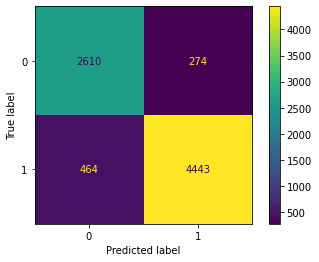

In [28]:
metrics.plot_confusion_matrix(classifier_DT, x_test, y_test)

In [29]:
print(confusion_matrix(y_test, y_predicted))

[[2610  274]
 [ 464 4443]]


### General Report of the Model

In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      2884
           1       0.94      0.91      0.92      4907

    accuracy                           0.91      7791
   macro avg       0.90      0.91      0.90      7791
weighted avg       0.91      0.91      0.91      7791

